<a href="https://colab.research.google.com/github/plaban1981/Haystack_NLP/blob/main/Haystack_for_Neural_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Haystack for Neural Question Answering ?

* Haystack is a python framework for developing End to End question answering systems. 

* It is available both as an open source library and extended paid version.

* It provides a flexible way to use the latest NLP models to solve several QA tasks in real-world settings with huge data collections. 

* Haystack is useful for providing solutions to diverse QA tasks such as Financial Governance, Knowledge Base Search, Competitive intelligence etc.

https://analyticsindiamag.com/what-is-haystack-for-neural-question-answering/

## Core Idea behind HayStack Library

* Large Neural networks, especially ones with transformer-based architectures, perform extremely well not only on Extractive Question Answering but also on Generative Question Answering(QA). 

* But these models are computationally expensive and time-consuming. This makes them unusable in latency-sensitive applications. 

* HayStack solves this problem by prefiltering the documents using faster but less powerful solutions. This allows the Neural Model to complete inference in a small amount of time.

## Typical Haystack Pipeline


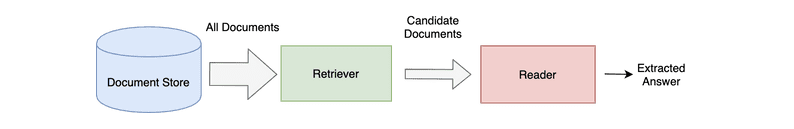

## Retriever

* **Retriever** is a lightweight filter that scans through all the documents in the Document store and identifies a small relevant candidate set of documents.

* **Retrievers** can be models using both sparse or dense methods.One very efficient retriever model is **ElasticSearch**.It is a proper sparse indexing based search engine.


## Reader

* The reader is a powerful model that closely examines each document and finds the answer to the question. 

* Using the latest models like the transformer models gives the Reader the capability to semantically extract information from documents instead of plain lexical search. 

* Reader models are generally built by adding a Question Answering Head on Language Models like BERT.

* To Do this, Deepset provides a framework called **FARM: Framework for Adapting Representation Models**. 
* This framework facilitates transfer learning on representation models.

In [1]:
!pip install farm-haystack

     |████████████████████████████████| 180 kB 7.3 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 3.4 MB 61.4 MB/s 
     |████████████████████████████████| 52 kB 973 kB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 330 kB 63.7 MB/s 
     |████████████████████████████████| 204 kB 77.2 MB/s 
     |████████████████████████████████| 981 kB 70.9 MB/s 
     |████████████████████████████████| 8.4 MB 19.5 MB/s 
     |████████████████████████████████| 100 kB 9.6 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 321 kB 76.9 MB/s 
     |████████████████████████████████| 5.6 MB 10.8 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 79 kB 9.5 MB/s 
     |████████████████████████████████| 402 kB 72.4 MB/s 
     |████████████████████████████████| 3.8 MB 46.3 MB/s 
     |██████████████████████

In [2]:
 !pip install urllib3==1.25.4 

     |████████████████████████████████| 125 kB 6.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## For the retriever model, we can use many models ranging from simple TFIDFReader to ElasticSearch. Let’s see how to set up an elastic search.

In [3]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
                    stdout=PIPE, stderr=STDOUT,
                    preexec_fn=lambda: os.setuid(1)  # as daemon
                   )
# wait until ES has started
! sleep 30 

## Importing functions from haystack

In [5]:
from haystack import Finder
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
from haystack.reader.farm import FARMReader
from haystack.reader.transformers import TransformersReader
from haystack.utils import print_answers 

In [8]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")
# Let's first get some documents that we want to query
# Here: 517 Wikipedia articles for Game of Thrones
doc_dir = "data/article_txt_got"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)
# convert files to dicts containing documents that can be indexed to our datastore
# You can optionally supply a cleaning function that is applied to each doc (e.g. to remove footers)
# It must take a str as input, and return a str.
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)
# We now have a list of dictionaries that we can write to our document store.
# If your texts come from a different source (e.g. a DB), you can of course skip convert_files_to_dicts() and create the dictionaries yourself.
# The default format here is: {"name": "<some-document-name>, "text": "<the-actual-text>"}
# Let's have a look at the first 3 entries:
print(dicts[:3])
# Now, let's write the docs to our DB.
document_store.write_documents(dicts) 

08/16/2021 16:39:08 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.077s]
08/16/2021 16:39:08 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.395s]
08/16/2021 16:39:08 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.224s]
08/16/2021 16:39:08 - INFO - haystack.preprocessor.utils -   Found data stored in `data/article_txt_got`. Delete this first if you really want to fetch new data.
08/16/2021 16:39:08 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/511_After_the_Thrones.txt
08/16/2021 16:39:08 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/306_The_Dance_of_Dragons.txt
08/16/2021 16:39:08 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/120_And_Now_His_Watch_Is_Ended.txt
08/16/2021 16:39:08 - INFO - haystack.preprocessor.utils -   Converting data/article_txt_got/12_Fire.txt
08/16/2021 16:39:08 - INFO - haystack.prepro

[{'text': "'''''After the Thrones''''' is an American live television aftershow that premiered on April 25, 2016, and ended on June 28, 2016. It was hosted by Andy Greenwald and Chris Ryan who discussed episodes of the HBO television series ''Game of Thrones''. The talk show is executive produced by Bill Simmons and Eric Weinberger. Greenwald and Ryan previously hosted a podcast version of the show titled ''Watch the Thrones'' on Simmons' Grantland website. A similar talk show called ''Thronecast'' airs on British channel Sky Atlantic, which also discusses episodes of ''Game of Thrones''.\nThe talk show was made available to HBO and HBO Now subscribers, and airs on the Monday following each episode of ''Game of Thrones''. After the show's cancellation, Greenwald and Ryan, along with Simmons, made a similar live stream video podcast for distribution on Twitter called ''Talk the Thrones''. Although it covers the same subject matter, it is a different production.", 'meta': {'name': '511_A

08/16/2021 16:39:11 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.397s]
08/16/2021 16:39:12 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.164s]
08/16/2021 16:39:13 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.074s]
08/16/2021 16:39:14 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.034s]
08/16/2021 16:39:15 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.072s]


## Model Pipeline

In [9]:
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)
reader = FARMReader(model_name_or_path="distilbert-base-uncased-distilled-squad", use_gpu=True)
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever) 

08/16/2021 16:39:51 - INFO - farm.utils -   Using device: CPU 
08/16/2021 16:39:51 - INFO - farm.utils -   Number of GPUs: 0
08/16/2021 16:39:51 - INFO - farm.utils -   Distributed Training: False
08/16/2021 16:39:51 - INFO - farm.utils -   Automatic Mixed Precision: None
08/16/2021 16:39:51 - INFO - filelock -   Lock 140090134969104 acquired on /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75.lock


Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

08/16/2021 16:39:51 - INFO - filelock -   Lock 140090134969104 released on /root/.cache/huggingface/transformers/ab70e5f489e00bb2df55e4bae145e9b1c7dc794cfa0fd8228e1299d400613429.f3874c2af5400915dc843c97f502c5d30edc728e5ec3b60c4bd6958e87970f75.lock
08/16/2021 16:39:52 - INFO - filelock -   Lock 140090147719248 acquired on /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf.lock


Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

08/16/2021 16:39:59 - INFO - filelock -   Lock 140090147719248 released on /root/.cache/huggingface/transformers/b00ff18397f70f871bd8f11949a3c5ffd5fb18fd6d4e3df947dc386950b8d59d.69a963759b72d26fb77afa9b7d43c9107b99dfe7ca78af52e0237c8d001c7dcf.lock
Some weights of the model checkpoint at distilbert-base-uncased-distilled-squad were not used when initializing DistilBertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
08/16/2021 16:40:03 - INFO - filelock -   Lock 140090131843856 acquired on /root/.cache/huggingface/transformers/03db

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

08/16/2021 16:40:03 - INFO - filelock -   Lock 140090131843856 released on /root/.cache/huggingface/transformers/03dbd2b11eae924dfd97070ed60502df863584957419a604e1c039e0eab3f974.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
08/16/2021 16:40:03 - INFO - filelock -   Lock 140090131843856 acquired on /root/.cache/huggingface/transformers/8785a0072d807ebc8a3b6bf5648744bfc3cc83e0e845c40b670d10c0d7827164.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

08/16/2021 16:40:04 - INFO - filelock -   Lock 140090131843856 released on /root/.cache/huggingface/transformers/8785a0072d807ebc8a3b6bf5648744bfc3cc83e0e845c40b670d10c0d7827164.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
08/16/2021 16:40:05 - INFO - filelock -   Lock 140090132728144 acquired on /root/.cache/huggingface/transformers/c0abea01d3725dc3c06370cced02822e09a715c98c62346f5ec9b730361df18d.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

08/16/2021 16:40:05 - INFO - filelock -   Lock 140090132728144 released on /root/.cache/huggingface/transformers/c0abea01d3725dc3c06370cced02822e09a715c98c62346f5ec9b730361df18d.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
08/16/2021 16:40:05 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
08/16/2021 16:40:05 - INFO - farm.utils -   Using device: CPU 
08/16/2021 16:40:05 - INFO - farm.utils -   Number of GPUs: 0
08/16/2021 16:40:05 - INFO - farm.utils -   Distributed Training: False
08/16/2021 16:40:05 - INFO - farm.utils -   Automatic Mixed Precision: None
08/16/2021 16:40:05 - INFO - farm.infer -   Got ya 2 parallel workers to do inference ...
08/16/2021 16:40:05 - INFO - farm.infer -    0    0 
08/16/2021 16:40:05 - INFO - farm.infer -   /w\  /w\
08/16/2021 16:40:05 - INFO - farm.infer -   /'\  / \
08/16/2021 16:40:05 - INFO - farm.infer -     


## You can visualize the pipeline built using haystack

In [13]:
pip install pygraphviz

     |████████████████████████████████| 118 kB 6.6 MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165753 sha256=9bb45e079bae1f904a0bce22ecd7a95c68582a7c418151e418eef9d7df385214
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [11]:
!sudo apt install libgraphviz-dev graphviz 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ub

In [14]:
pipe.draw()